No notebook anterior, nós aprendemos sobre o Perceptron. Vimos como ele aprende e como pode ser utilizado tanto para classificação binária quanto para regressão linear. Nesse notebook, nós veremos um algoritmo muito parecido com o Perceptron, mais conhecido como __Adaline__, que foi uma proposta de melhoria ao algoritmo original do Perceptron. Veremos as semelhanças e diferenças entre os dois algoritmos e iremos implementá-lo utilizando python, numpy, Tensorflow e Keras. Por fim, vamos aplicar nos mesmos problemas de classificação do notebook do Perceptron para entender de fato suas diferenças. __O código para utilizar o Adaline em problemas de regressão é exatamente o mesmo do perceptron, só muda a forma como calculamos o custo__.

__Objetivos__:

- Entender as diferenças entre os algoritmos do Perceptron e Adaline.
- Implementar o Adaline e seu modelo de aprendizado em python puro, Numpy, Keras e Tensorflow
- Utilizar o Adaline para classificação, já que para regressão, o código é o mesmo do Perceptron

# Sumário

[Introdução](#Introdução)

[Regra de Aprendizado do Adaline](#Regra-de-Aprendizado-do-Adaline)

[Classificação](#Classificação)
- [Porta AND/OR](#Porta-AND/OR)
- [Exercício de Classificação](#Exerc%C3%ADcio-de-Classificação)

# Imports e Configurações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from random import random
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.initializers import RandomUniform
from keras.optimizers import SGD
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

Using TensorFlow backend.


# Introdução

Poucos meses após a publicação do teorema da convergência do Perceptron por Rosenblatt, os engenheiros da Universidade de Stanford Bernard Widrow e Marcian Hoff publicaram um trabalho descrevendo uma rede neural muito parecida com o Perceptron, a __Adaline__ (do inglês _ADAptive LINear Element_). Porém, ao invés de utilizar a função _step_ como função de ativação, a __Adaline utiliza função de ativação linear e tem uma nova regra de aprendizado supervisionado__, conhecida como __regra de Widrow-Hoff__ (ou __regra delta__, ou ainda __regra LMS__). 

De fato, tanto o Perceptron quanto o Adaline possuem muitas características semelhantes e __é comum ver o pessoal confundindo o Perceptron com o Adaline__. Entre as principais semelhanças, podemos destacar:
- Ambos possuem __apenas um neurônio de N entradas e apenas uma saída. Não há camadas escondidas__.
- Ambos são __classificadores lineares binários__ por definição, mas podemos adaptá-los para efetuar __regressão linear__, da mesma forma como vimos no notebook sobre o Perceptron. __Na verdade, o código para treinar um Adaline para regressão é o mesmo de um Perceptron, só muda o modo como calculamos o custo__. No Adaline, o custo é dado pela soma dos erros quadrados (MSE), enquanto no Perceptron é dado pela soma dos erros.
- Ambos tem o **método de aprendizagem _online_**. Isto é, a atualização dos pesos é efetuada amostra por amostra.
- Ambos tem uma **função _step_ para classificação**. Porém, ao contrário do Perceptron, __na Adaline ela não é utilizada na atualização dos pesos__. Nós veremos por que a seguir.

Porém, a principal diferença entre o Perceptron e a Adaline é que o Perceptron utiliza os labels das classes para fazer a atualização dos pesos, enquanto __a Adaline utiliza o resultado da função de ativação (linear) como valor contínuo de predição__. Isto é, ao invés da saída ser discreta como no Perceptron (0 ou 1), __na Adaline a saída pode ser qualquer valor contínuo__. Essa diferença fica mais clara quando vemos a figura a seguir:

<img src="images/comparacao_perceptron_adaline.png">
[Fonte](https://www.quora.com/What-is-the-difference-between-a-Perceptron-Adaline-and-neural-network-model)

Repare, como dito, que ambos têm a função _step_. No Perceptron, ela é utilizada como função de ativação. No Adaline, por sua vez, a função de ativação é linear e a funcão _step_ é utilizada para gerar a predição. 

Por calcular a saída como um valor contínuo, __muitos consideram o Adaline mais poderoso__, uma vez que a diferença entre a saída desejada e o valor predito ($y_i - y_{pred_i}$) nos diz agora "o quanto estamos certos ou errados". __Na prática, isso faz com o que o Adaline tente encontrar a "melhor solução" para o problema, ao invés de somente uma "solução adequada"__. Tomando como exemplo a figura abaixo, o Perceptron pode encontrar diversas retas que separam as classes, enquanto o Adaline tenta encontrar a melhor reta que separa as classes.

<img src="images/hiperplanos_perceptron_adaline.png" width='700'>

[Fonte](http://www.barbon.com.br/wp-content/uploads/2013/08/RNA_Aula4.pdf)

Ok, mas como isso muda o aprendizado? É o que veremos a seguir.

## Regra de Aprendizado do Adaline

A atualização dos pesos do Adaline é dada pela mesma fórmula do Perceptron:

$$w_i = w_i + \lambda(y_i - y_{pred_i})x_i$$

Onde $\lambda$ é a __taxa de aprendizagem__.

Mas você já imaginou da onde vem essa fórmula? Em primeiro lugar, o método de atualização dos pesos é baseado na __Regra Delta__ (*Delta Rule*). Sendo $\overrightarrow{w} = \{w_1, w_2, ..., w_D\}$, a atualização dos pesos é dada por:

$$\overrightarrow{w} = \overrightarrow{w} - \Delta{\overrightarrow{w}}$$

em que:

$$\Delta{\overrightarrow{w}} = \lambda\nabla E(\overrightarrow{w})$$

Sendo $\nabla E(\overrightarrow{w})$ o gradiente de uma função que depende de $\overrightarrow{w}$ e que queremos minimizar.

No caso do Adaline, __a função de custo é dada pela soma dos erros quadrados__:

$$J(w) = \frac{1}{2}\sum_{i}^N (y_i - y_{pred_i})^2$$

Onde $N$ é a quantidade de amostras nos dados, e as demais variáveis representam as mesmas vistas anteriormente. Repare que a função de custo é quase uma _Mean Squared Error (MSE)_, só que ao invés de dividir por $N$, estamos dividindo por 2 o resultado do somatório. O por quê disso será entendido mais a frente na demonstração.

Queremos encontrar, então, o vetor $\overrightarrow{w}$ que minimiza a função $J$. Assim, temos:

$$\frac{\partial J}{\partial w_i} = \frac{\partial}{\partial w_i}\frac{1}{2}\sum_i^N (y_i - y_{pred_i})^2$$

Como a derivada do somatório é igual ao somatório das derivadas:

$$= \frac{1}{2}\sum_i^N \frac{\partial}{\partial w_i}(y_i - y_{pred_i})^2$$

Aplicando a regra da cadeia:

$$= \sum_i^N (y_i - y_{pred_i})\frac{\partial}{\partial w_i}(y_i - y_{pred_i})$$

Repare que, quando derivamos $(y_i - y_{pred_i})^2$, o expoente 2, ao sair do somatório, foi multiplicado por $\frac{1}{2}$, tornando-o 1. Isso é o que os matemáticos denominam de "conveniência matemática". 

Como $y_{pred_i} = x_iw_i + b$ é uma função que depende de $w$, e sua derivada em relação a $w_i$ é apenas $x_i$, temos que:

$$\frac{\partial J}{\partial w_i} = \sum_i^N (y_i - y_{pred_i})(-x_i)$$
$$\frac{\partial J}{\partial w_i} = -\sum_i^N (y_i - y_{pred_i})x_i$$

$$\frac{\partial J}{\partial \overrightarrow{w}} = -(\overrightarrow{y} - \overrightarrow{y}_{pred})\overrightarrow{x}$$

De maneira análoga, podemos calcular que a derivada de $J$ em relação a $b_i$ é:

$$\frac{\partial J}{\partial b_i} = -\sum_i^N (y_i - y_{pred_i})*1.0$$

Já que a derivada de $y_{pred_i}$ em relação a $b_i$ ($\frac{\partial J}{\partial b_i}$) é igual a 1.0. Logo, a atualização dos bias será dada por:

$$b_i = b_i + \lambda(y_i - y_{pred_i})$$

# Classificação

## Porta AND/OR

In [2]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
# y = np.array([[0, 1, 1, 1]]).T # porta OR
y = np.array([[0, 0, 0, 1]]).T # porta AND

# se quisermos ver os resultados no notebook da intuição, devemos alterar o threshold para 0.5

print(x.shape, y.shape)

(4, 2) (4, 1)


### Python

In [3]:
D = x.shape[1]
w = [2*random() - 1 for i in range(D)] # [1xD]
b = 2*random() - 1 # [1x1]

# Para uma lr alta (0.1), o Adaline sempre chega na melhor solução, por que ele consegue convergir em 101 epochs.
# Porém, quando baixamos a lr, temos que aumenta #epochs, pois ele demora mais a convergir
learning_rate = 1e-1

for step in range(101):
    cost = 0
    for x_i, y_i in zip(x, y):
        y_pred = sum([x_i[d]*w[d] for d in range(D)]) + b
        error = y_i - y_pred
        w = [w[d] + learning_rate*error*x_i[d] for d in range(D)]
        b = b + learning_rate*error
        cost += error**2
        
    if step%10 == 0:
        print('step {0}: {1}'.format(step, cost))

print('w: ', w)
print('b: ', b)
print('y_pred: {0}'.format(np.dot(x, np.array(w))+b))

step 0: [ 4.4323598]
step 10: [ 0.94505546]
step 20: [ 0.46532124]
step 30: [ 0.3459333]
step 40: [ 0.31685004]
step 50: [ 0.31008921]
step 60: [ 0.30868827]
step 70: [ 0.30849188]
step 80: [ 0.30852232]
step 90: [ 0.3085705]
step 100: [ 0.30860312]
w:  [array([ 0.55460155]), array([ 0.52677261])]
b:  [-0.27645548]
y_pred: [[-0.27645548]
 [ 0.25031714]
 [ 0.27814608]
 [ 0.80491869]]


### Numpy

In [4]:
D = x.shape[1]
w = 2*np.random.random((1, D))-1
b = 2*np.random.random()-1       

learning_rate = 1e-1

for step in range(100):
    cost = 0
    for x_i, y_i in zip(x, y):
        x_i = x_i.reshape(1, D)
        y_pred = np.dot(x_i, w.T) + b 
        error = y_i - y_pred
        w = w + learning_rate*np.dot(error.T, x_i)
        b = b + learning_rate*error
        cost += error**2
    
    if step%10 == 0:
        print('step {0}: {1}'.format(step, cost))
    
print('w: ', w)
print('b: ', b)
print('y_pred: {0}'.format(np.dot(w, x.T)+b))

step 0: [[ 1.6140212]]
step 10: [[ 0.54949818]]
step 20: [[ 0.36104314]]
step 30: [[ 0.32004466]]
step 40: [[ 0.310839]]
step 50: [[ 0.30886975]]
step 60: [[ 0.30853332]]
step 70: [[ 0.30852957]]
step 80: [[ 0.30857028]]
step 90: [[ 0.30860188]]
w:  [[ 0.55501046  0.5271888 ]]
b:  [[-0.27701257]]
y_pred: [[-0.27701257  0.25017623  0.2779979   0.8051867 ]]


### Keras

In [5]:
D = x.shape[1]

model = Sequential()
model.add(Dense(units=1, activation='linear', input_dim=D))
model.compile(loss='mse', optimizer=SGD(lr=1e-1))

In [6]:
model.fit(x, y, epochs=1000, batch_size=x.shape[0], verbose=0)
y_pred = model.predict(x, verbose=0)
error = model.evaluate(x, y, batch_size=x.shape[0], verbose=0)
w, b = model.get_weights()

print('error: ', error)
print('w:', w)
print('b:', b)
print('y_pred:', y_pred)

error:  0.0625
w: [[ 0.49999967]
 [ 0.49999967]]
b: [-0.24999964]
y_pred: [[-0.24999964]
 [ 0.25000003]
 [ 0.25000003]
 [ 0.7499997 ]]


### TensorFlow

In [7]:
D = x.shape[1]

learning_rate = 1e-1
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    g_x = tf.placeholder(dtype=tf.float64, shape=(None, D))
    g_y = tf.placeholder(dtype=tf.float64)
    
    g_w = tf.Variable(tf.random_uniform(shape=(1, D), minval=-1, maxval=1, dtype=tf.float64))
    g_b = tf.Variable(tf.random_uniform(shape=(1,), minval=-1, maxval=1, dtype=tf.float64))
    
    y_pred = tf.add(tf.matmul(g_x, g_w, transpose_b=True), g_b)
    y_pred_bin = tf.where(y_pred > 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    g_error = tf.subtract(g_y, y_pred)
    
    delta = tf.matmul(g_error, g_x, transpose_a=True)
    train_w = tf.assign(g_w, tf.add(g_w, learning_rate*delta))
    train_b = tf.assign(g_b, tf.add(g_b, learning_rate*tf.squeeze(g_error)))

In [8]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for step in range(101):
        cost = 0
        for x_i, y_i in zip(x, y):
            feed_dict = {g_x:x_i.reshape((1,D)), g_y:y_i}
            error, _, _ = sess.run([g_error, train_w, train_b], feed_dict=feed_dict)
            cost += error**2

        if step%10 == 0:
            print('step {0}: {1}'.format(step, cost))
    
    y_pred = sess.run([y_pred], feed_dict={g_x:x, g_y:y})
    print('w: ', g_w.eval())
    print('b: ', g_b.eval())
    print('y_pred:', y_pred)

step 0: [[ 2.58937709]]
step 10: [[ 0.35754219]]
step 20: [[ 0.31602985]]
step 30: [[ 0.30940007]]
step 40: [[ 0.30844065]]
step 50: [[ 0.30841619]]
step 60: [[ 0.30850112]]
step 70: [[ 0.30856526]]
step 80: [[ 0.3086022]]
step 90: [[ 0.30862175]]
step 100: [[ 0.30863178]]
w:  [[ 0.5553213   0.52753911]]
b:  [-0.27745847]
y_pred: [array([[-0.27745847],
       [ 0.25008064],
       [ 0.27786283],
       [ 0.80540194]])]


## Exercício de Classificação

(100, 2) (100, 1)


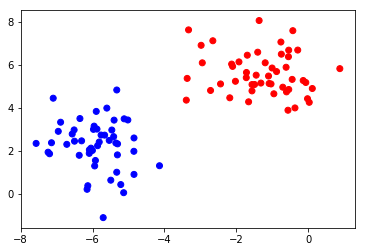

In [2]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=y, cmap='bwr')

In [3]:
def plot_linear_classifier(x, y, w, b):
    x1_min, x1_max = x[:,0].min(), x[:,0].max()
    x2_min, x2_max = x[:,1].min(), x[:,1].max()

    x1, x2 = np.meshgrid(np.linspace(x1_min-1, x1_max+1,100), np.linspace(x2_min-1, x2_max+1, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T

    plt.scatter(x[:,0], x[:,1], c=y, cmap='bwr')

    y_mesh = np.dot(x_mesh, w.T) + b
    y_mesh = np.where(y_mesh < 0.5, 0, 1)

    plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap='bwr', alpha=0.5)
    plt.xlim(x1_min-1, x1_max+1)
    plt.ylim(x2_min-1, x2_max+1)

### Python

step 0: 422.42080930107517
step 100: 6.549204173101313
step 200: 4.19414109230637
step 300: 3.0892593378008693
step 400: 2.5710633171538815
step 500: 2.328136794366998
step 600: 2.2143303604299627
step 700: 2.1610661990471476
step 800: 2.13617297369577
step 900: 2.1245635512478267
step 1000: 2.1191661621472346
w:  [0.1389629954321121, 0.082489206449305852]
b:  0.666577172365


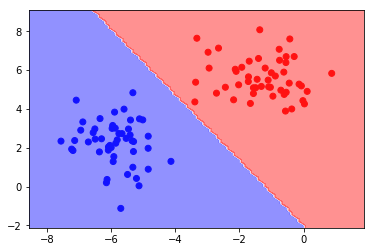

In [4]:
D = x.shape[1]
w = [2*random() - 1 for i in range(D)] # [1xD]
b = 2*random() - 1 # [1x1]

learning_rate = 1e-3

for step in range(1001):
    cost = 0
    for x_i, y_i in zip(x, y):
        y_pred = sum([w[d]*x_i[d] for d in range(D)]) + b
        error = y_i[0] - y_pred
        w = [w[d] + learning_rate*error*x_i[d] for d in range(D)]
        b = b + learning_rate*error
        cost += error**2
        
    if step%100 == 0:
        print('step {0}: {1}'.format(step, cost))

print('w: ', w)
print('b: ', b)

plot_linear_classifier(x, y, np.array(w), b)

### Numpy

step 0: [[ 50.87762542]]
step 100: [[ 2.2150401]]
step 200: [[ 2.16139814]]
step 300: [[ 2.13632795]]
step 400: [[ 2.12463571]]
step 500: [[ 2.11919963]]
step 600: [[ 2.11668392]]
step 700: [[ 2.11552778]]
step 800: [[ 2.11500207]]
step 900: [[ 2.11476696]]
step 1000: [[ 2.1146646]]
w:  [[ 0.14218264  0.07824944]]
b:  [[ 0.69637833]]


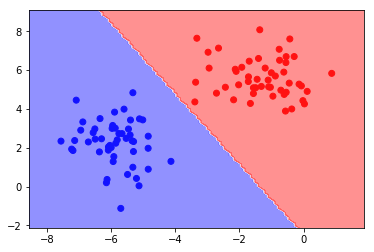

In [5]:
D = x.shape[1]
w = 2*np.random.random((1, D))-1
b = 2*np.random.random()-1       

learning_rate = 1e-3

for step in range(1001):
    cost = 0
    for x_i, y_i in zip(x, y):
        x_i = x_i.reshape(1, D)
        y_pred = np.dot(x_i, w.T) + b 
        error = y_i - y_pred
        w = w + learning_rate*np.dot(error.T, x_i)
        b = b + learning_rate*error
        cost += error**2
    
    if step%100 == 0:
        print('step {0}: {1}'.format(step, cost))
    
print('w: ', w)
print('b: ', b)

plot_linear_classifier(x, y, w, b)

### Keras

In [6]:
D = x.shape[1]

model = Sequential()
model.add(Dense(units=1, activation='linear', input_dim=D))
model.compile(loss='mse', optimizer=SGD(lr=1e-2))

0.0204534716904
[[ 0.13967788]
 [ 0.08242235]] [ 0.67758703]


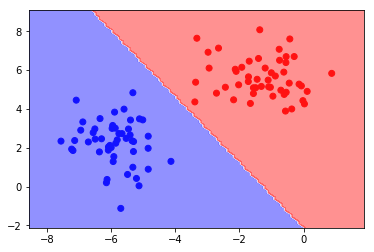

In [9]:
model.fit(x, y, epochs=2000, batch_size=x.shape[0], verbose=0)
y_pred = model.predict(x, verbose=0)
error = model.evaluate(x, y, batch_size=x.shape[0], verbose=0)
w, b = model.get_weights()
print(error)
print(w,b)

plot_linear_classifier(x, y, w.reshape(1, 2), b)

### Tensorflow

In [10]:
D = x.shape[1]

learning_rate = 1e-3
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    g_x = tf.placeholder(dtype=tf.float64, shape=(None, D))
    g_y = tf.placeholder(dtype=tf.float64)
    
    g_w = tf.Variable(tf.random_uniform(shape=(1, D), minval=-1, maxval=1, dtype=tf.float64))
    g_b = tf.Variable(tf.random_uniform(shape=(1,), minval=-1, maxval=1, dtype=tf.float64))
    
    y_pred = tf.add(tf.matmul(g_x, g_w, transpose_b=True), g_b)
    y_pred_bin = tf.where(y_pred > 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    g_error = tf.subtract(g_y, y_pred)
    
    delta = tf.matmul(g_error, g_x, transpose_a=True)
    train_w = tf.assign(g_w, tf.add(g_w, learning_rate*delta))
    train_b = tf.assign(g_b, tf.add(g_b, learning_rate*tf.squeeze(g_error)))

step 0: [[ 169.4397614]]
step 100: [[ 7.22325287]]
step 200: [[ 4.51041215]]
step 300: [[ 3.23761974]]
step 400: [[ 2.6406324]]
step 500: [[ 2.36074149]]
step 600: [[ 2.229599]]
step 700: [[ 2.16820815]]
step 800: [[ 2.13950795]]
step 900: [[ 2.12611692]]
step 1000: [[ 2.119887]]
w:  [[ 0.13868514  0.08285509]]
b:  [ 0.66400536]


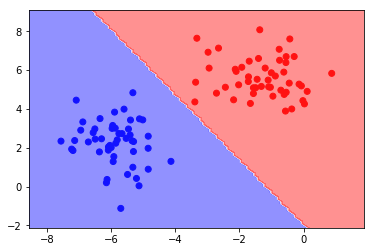

In [11]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for step in range(1001):
        cost = 0
        for x_i, y_i in zip(x, y):
            feed_dict = {g_x:x_i.reshape((1,D)), g_y:y_i}
            error, _, _ = sess.run([g_error, train_w, train_b], feed_dict=feed_dict)
            cost += error**2

        if step%100 == 0:
            print('step {0}: {1}'.format(step, cost))
    
    print('w: ', g_w.eval())
    print('b: ', g_b.eval())
    plot_linear_classifier(x, y, g_w.eval(), g_b.eval())

# Referências

- [http://sisne.org/Disciplinas/PosGrad/PsicoConex/aula6.pdf](http://sisne.org/Disciplinas/PosGrad/PsicoConex/aula6.pdf)
- [What is the difference between a Perceptron, Adaline, and neural network model?](https://www.quora.com/What-is-the-difference-between-a-Perceptron-Adaline-and-neural-network-model)
- [RNA – Adaline e Regra do Delta](http://www.barbon.com.br/wp-content/uploads/2013/08/RNA_Aula4.pdf)